<a href="https://colab.research.google.com/github/abialbon/pytorch-udacity-scholarship/blob/master/Project/Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


tcmalloc: large alloc 1073750016 bytes == 0x59106000 @  0x7f22ed4d12a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -cq https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
#!unzip -qq flower_data.zip

In [4]:
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://github.com/cahya-wirawan/Udacity-Course/blob/master/flower_test.tgz" "https://raw.githubusercontent.com/cahya-wirawan/Udacity-Course/master/flower_test.tgz" -O "flower_test.tgz" -c

--2018-12-24 17:17:30--  https://raw.githubusercontent.com/cahya-wirawan/Udacity-Course/master/flower_test.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34889082 (33M) [application/octet-stream]
Saving to: ‘flower_test.tgz’

flower_test.tgz     100%[===================>]  33.27M   110MB/s    in 0.3s    

2018-12-24 17:17:31 (110 MB/s) - ‘flower_test.tgz’ saved [34889082/34889082]



In [0]:
!tar xzf flower_test.tgz

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    classes_to_labels = json.load(f)

In [2]:
# All imports
import time
import torch
import numpy as np
from torchvision import datasets, models, transforms
from torch import nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [0]:
def recreate_model(c):
    from torchvision import models
    model = models.resnet152(pretrained=False)

    fc = nn.Sequential(nn.Linear(2048, 102),
                  nn.LogSoftmax(dim=1))

    model.fc = fc
    model.load_state_dict(c['state_dict'], strict=False)
    model.class_to_idx = c['class_to_idx']
    model.to(device)
    return model

checkpoint = torch.load('drive/My Drive/job_/model_over_train_transformation.pt')
new_model = recreate_model(checkpoint)

In [0]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])


In [0]:
recode = {i: j for j, i in new_model.class_to_idx.items()}

In [0]:
def predict(model, path):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    try:
        image = Image.open(path)
        t_image = train_transforms(image)
        
    except:
        t_image = path
    
    t_image = t_image.unsqueeze(0).to(device)
    model.eval()
   
    with torch.no_grad():
        output = model.forward(t_image)
        probs = torch.exp(output)
        probs, top_c = probs.topk(5)
        top_c = top_c.squeeze().detach().cpu().numpy()
        top_c = [recode[x] for x in top_c]
        labels = [classes_to_labels[str(i)] for i in top_c]
        print('The prediction is {}'.format(labels[0]))
        
    _, ax = plt.subplots(1, 2)
    _.set_size_inches(15, 5)
    #plotting the image
    np_img = t_image.detach().cpu().numpy().squeeze()
    np_img = np_img.transpose(1, 2, 0).reshape(-1, 3)
    np_img = np.multiply(np_img,std) + mean
    np_img = np.clip(np_img, 0, 1)
    ax[0].set_axis_off()
    ax[0].imshow(np_img.reshape(224, 224, 3))
    
    #plot the probs
    ax[1].barh(labels, probs.squeeze().cpu().numpy())
    
    


The prediction is globe thistle


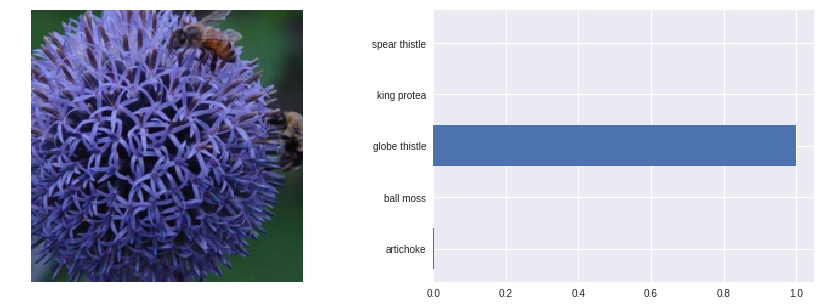

In [7]:
predict(new_model, 'test/10/image_07090.jpg')

In [8]:
classes_to_labels['10']

'globe thistle'

In [0]:
test_images = datasets.ImageFolder('test', transform=train_transforms)
testloader = torch.utils.data.DataLoader(test_images, batch_size=64)

The prediction is trumpet creeper


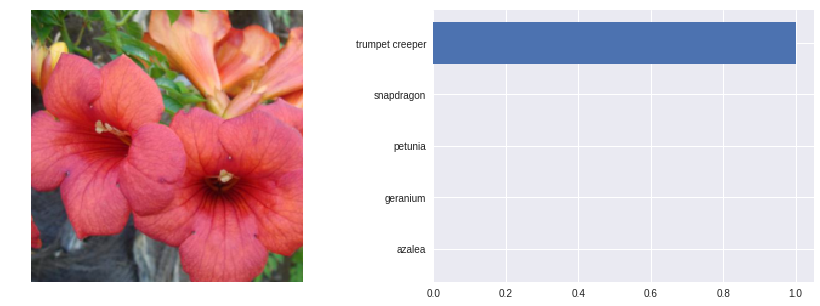

In [10]:
x, y = next(iter(testloader))
predict(new_model, x[18])

In [11]:
criteria = nn.NLLLoss()
accuracy = 0
new_model.eval()
for images, labels in testloader:
    with torch.no_grad():
            images, labels = images.to(device), labels.to(device)

            output = new_model.forward(images)
            loss = criteria(output, labels)
            probs = torch.exp(output)
            prob, top_c = probs.topk(1)

            equals = top_c.squeeze() == labels
            equals = equals.type(torch.FloatTensor).mean()
            accuracy += equals.item()
else:
    print(accuracy/len(testloader))

1.0
